<a href="https://colab.research.google.com/github/leticiacaldas/Relatorio-3-CNC/blob/main/Relat%C3%B3rio3_Let%C3%ADciaBrand%C3%A3oCaldas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Universidade Federal de Pelotas**

**Cursos de Ciência e Engenharia de Computação**

**Disciplina: Cálculo Numérico Computacional**

Relatório 3 - Interpolação e Ajuste de Função


In [ ]:
from pandas import DataFrame



data1 = {
    'T [K]': [200, 250, 300, 350, 400, 450],
    'Densidade [kg/m^3]': [1.708, 1.367, 1.139, 0.967, 0.854, 0.759]
}
df1 = DataFrame(data1)
Table1 = df1.T



data2 = {
    'T [ºC]': [370, 382, 394, 406, 418],
    '$\nu$ [Litro/kg]': [5.9313, 7.5838, 8.8428, 9.7960, 10.5311]
}
df2 = DataFrame(data2)
Table2 = df2.T



data3 = {
    '$x$': [1.8, 2., 2.2, 2.4, 2.6],
    '$J_1(x)$': [0.5815, 0.5767, 0.5560, 0.5202, 0.4708]
}
df3 = DataFrame(data3)
Table3 = df3.T



data4 = {
    'T [ºC]': [0., 5., 10., 20., 30., 40.],
    '$\mu$ [$10^{-3}$ N.s/$m^2$]': [1.787, 1.519, 1.307, 1.002, 0.7975, 0.6529]
}
df4 = DataFrame(data4)
Table4 = df4.T

In [ ]:
#Funções auxiliares
import matplotlib.pyplot as plt
import numpy as np
#================================================================================
def lagrange(ponto, x, y):

    '''Função que interpola pontos pelo método de Lagrange'''
    grau = len(x) - 1
    valor = 0.              # estimativa pelo metodo de lagrange

    for k in range(grau + 1):
        Lk = 1.          # variavel que armezena os 'L's
        for j in range(grau + 1):
            if j != k:   # índices k e j não podem ser iguais
                Lk *= (ponto - x[j])/(x[k] - x[j])   # Cálculo do L
        valor += y[k]*Lk   # calculo da estimativa, L_0*f(x_0) + L_1*f(x_1) ...

    return valor

#================================================================================
def newton(ponto, x, y, print_df): # interpolacao pelo metodo de newton
    '''Função que interpola pontos pelo método de Newton'''
    n = len(x)         # quantidade de pontos
    dd_table = [[0. for x in range(n)] for x in range(n)]
    valor = [None for x in range(n)]

    for i in range(n):
        dd_table[i][0] = y[i]
    for j in range(1, n):
         for k in range(n-j):
                dd_table[k][j] = ((dd_table[k+1][j-1] - dd_table[k][j-1]) /
                                  (x[j+k] - x[k]))

    if print_df:
        dd_table_pd = DataFrame(dd_table)
        print(dd_table_pd)

    prod_x = 1.
    valor = dd_table[0][0]
    for ordem in range(1, n):
        prod_x *= ponto - x[ordem - 1]
        valor += dd_table[0][ordem]*prod_x

    return valor, dd_table


def minquad(x, y, base, numbase):

    n = len(x)      # quantidade de pontos conhecidos

    u = np.zeros((n,numbase))
    for i in range(n):
        u[i,:] = base(x[i])


    b = np.zeros(numbase)
    for i in range(numbase):
        b[i] = sum(u[:,i]*y)

    # Construir a matriz A
    A = np.zeros((numbase,numbase))
    for i in range(numbase):
        for j in range(numbase):
            A[i,j] = sum(u[:,i]*u[:,j]);

    coef = np.linalg.solve(A,b)

    return coef

#================================================================================
def spline_cubico(x, y):
    '''Função que calcula os coeficientes ddos splines cúbicos naturais'''

    m = len(x) - 1
    h = x[1:m + 1] - x[0:m]


    l, r, S = np.zeros(m), np.zeros(m), np.zeros(m + 1)
    a, b, c, d = np.zeros(m), np.zeros(m), np.zeros(m + 1), np.zeros(m)

    # Primeira equacao
    d[1] = 2 * (h[0] + h[1])
    r[1] = h[1]
    b[1] = 6 * ((y[2] - y[1]) / h[1] - (y[1] - y[0]) / h[0])

    # Equacoes intermediarias
    for i in range(2, m):
        l[i] = h[i - 1]
        d[i] = 2 * (h[i - 1] + h[i])
        r[i] = h[i]
        b[i] = 6 * ((y[i + 1] - y[i]) / h[i] - (y[i] - y[i - 1]) / h[i - 1])

    # Ultima equacao do sistema
    l[m - 1] = h[m - 2]
    d[m - 1] = 2 * (h[m - 2] + h[m - 1])
    b[m - 1] = 6 * ((y[m] - y[m - 1]) / h[m - 1] - (y[m - 1] - y[m - 2]) / h[m - 2])


    for i in range(2, m):  # Escalonamento
        mult = l[i] / d[i - 1]
        d[i] -= mult * r[i - 1]
        b[i] -= mult * b[i - 1]

    S[m - 1] = b[m - 1] / d[m - 1]
    for i in range(m - 2, 0, -1):
        S[i] = (b[i] - r[i] * S[i + 1]) / d[i]

    # Splines naturais/lineares nas extremidades S1 = 0 e Sm+1 = 0
    S[0], S[m] = 0., 0.

    # Calculo dos coeficientes dos splines
    for i in range(m):
        a[i] = y[i]
        b[i] = (y[i + 1] - y[i]) / h[i] - (S[i + 1] + 2 * S[i]) * h[i] / 6
        c[i] = S[i] / 2
        d[i] = (S[i + 1] - S[i]) / (6 * h[i])

    return a, b, c, d

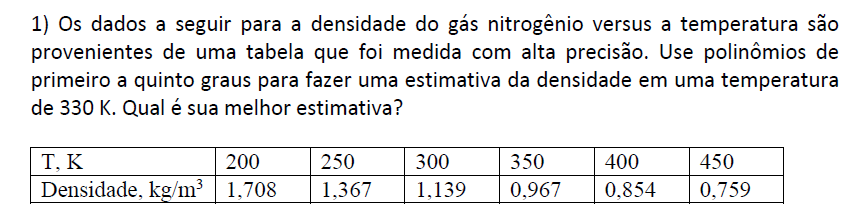

In [ ]:

x, y = data1['T [K]'], data1['Densidade [kg/m^3]']
#x, y = np.array(x), np.array(y)

ponto = 330                    # Ponto de interesse
print('Tabela de deferenças divididas:\n')
p5, dd_table5 = newton(ponto, x, y, True)
print('-'*70)

print(f'\nEstimando a densidade em T = {ponto} K:\n')

# Considerando x0 = 300 e x1 = 350, temos:
p1, dd_table = newton(ponto, x[2:4], y[2:4], False)
print(f'   - Através de um polinômio de primeiro grau:\n   Densidade estimada: {p1:.3f}')

# Considerando x0 = 300, x1 = 350 e x2 = 400, temos:
p2, dd_table = newton(ponto, x[2:5], y[2:5], False)
print(f'\n   - Através de um polinômio de segundo grau:\n   Densidade estimada: {p2:.3f}')

# Considerando x0 = 250, x1 = 300, x2 = 350 e x3 = 400, temos:
p3, dd_table = newton(ponto, x[1:5], y[1:5], False)
print(f'\n   - Através de um polinômio de terceiro grau:\n   Densidade estimada: {p3:.3f}')

# Considerando x0 = 250, x1 = 300, x2 = 350, x3 = 400 e x4 = 450, temos:
p4, dd_table = newton(ponto, x[1:], y[1:], False)
print(f'\n   - Através de um polinômio de quarto grau:\n   Densidade estimada: {p4:.3f}')

# Considerando todos os pontos, temos:
print(f'\n   - Através de um polinômio de quinto grau:\n   Densidade estimada: {p5:.3f}')

Tabela de deferenças divididas:

       0        1         2             3             4             5
0  1.708 -0.00682  0.000023 -7.600000e-08  4.000000e-10 -2.773333e-12
1  1.367 -0.00456  0.000011  4.000000e-09 -2.933333e-10  0.000000e+00
2  1.139 -0.00344  0.000012 -5.466667e-08  0.000000e+00  0.000000e+00
3  0.967 -0.00226  0.000004  0.000000e+00  0.000000e+00  0.000000e+00
4  0.854 -0.00190  0.000000  0.000000e+00  0.000000e+00  0.000000e+00
5  0.759  0.00000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00
----------------------------------------------------------------------

Estimando a densidade em T = 330 K:

   - Através de um polinômio de primeiro grau:
   Densidade estimada: 1.036

   - Através de um polinômio de segundo grau:
   Densidade estimada: 1.029

   - Através de um polinômio de terceiro grau:
   Densidade estimada: 1.029

   - Através de um polinômio de quarto grau:
   Densidade estimada: 1.028

   - Através de um polinômio de quinto grau:
   Densidade estim

Para decidir qual foi a melhor estimativa, podemos calcular os erros de interpolação. Sabe-se que, quando não conhecemos a função que gerou o conjunto de dados, o erro de interpolação pode ser majorado pela equação:
$$\varepsilon_n(x) = \prod_{k=0}^n|x-x_k|\left(\text{máximo do valor absoluto das
 diferenças divididas de ordem n+1}\right)$$

In [ ]:
# Calculando um limitante superior para o erro de interpolação para os polinômios de ordem 1 até 4.
dd_table, x = np.array(dd_table5), np.array(x)
E1 = abs(np.prod(ponto - x[2:4]))*np.max(np.abs(dd_table[:,2]))
E2 = abs(np.prod(ponto - x[2:5]))*np.max(np.abs(dd_table[:,3]))
E3 = abs(np.prod(ponto - x[1:5]))*np.max(np.abs(dd_table[:,4]))
E4 = abs(np.prod(ponto - x[1:]))*np.max(np.abs(dd_table[:,5]))

print('Estimativas para os erros de interpolação:')
print(f'   - De um polinômio de primeiro grau: {E1:.3e}')
print(f'   - De um polinômio de segundo grau: {E2:.3e}')
print(f'   - De um polinômio de terceiro grau: {E3:.3e}')
print(f'   - De um polinômio de quarto grau: {E4:.3e}')

Estimativas para os erros de interpolação:
   - De um polinômio de primeiro grau: 1.356e-02
   - De um polinômio de segundo grau: 3.192e-03
   - De um polinômio de terceiro grau: 1.344e-03
   - De um polinômio de quarto grau: 1.118e-03


Nota-se que o menor erro foi gerado utilizando o polinômio interpolador de quarto grau. Portanto, a melhor estimativa para a densidade corresponde à:

In [ ]:
print(f'Densidade estimada: {p4:.3f}')

Densidade estimada: 1.028


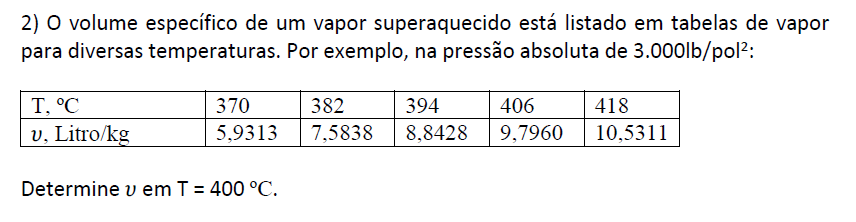

Uma maneira de resolver o problema é observando o gráfico de dispersão do conjunto de dados para, em seguida, observar se alguma função básica corriqueira neste contexto poderia se ajustar relativamente bem ao conjunto de pontos dados.

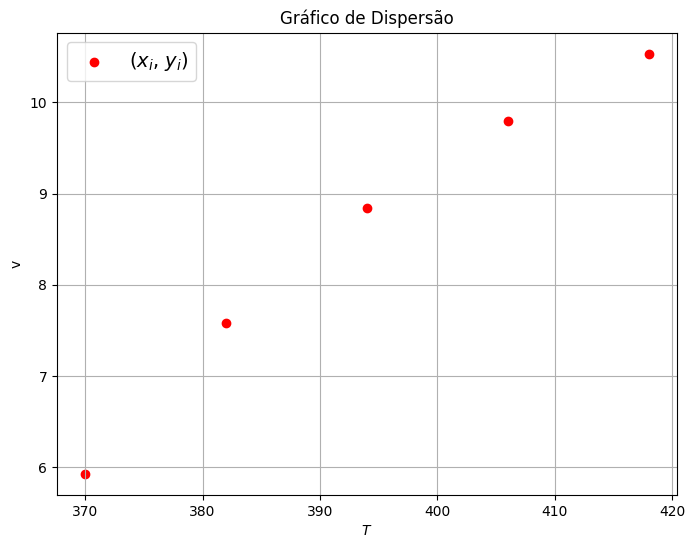

In [ ]:
x, y = data2['T [ºC]'], data2['$\nu$ [Litro/kg]']

plt.figure(figsize=(8, 6))
plt.title('Gráfico de Dispersão')
plt.grid()
plt.scatter(x, y, color='r', label='($x_i$, $y_i$)')
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.xlabel('$T$')
plt.ylabel('v')
plt.legend()
plt.show()

Ao observar o conjunto de dados na forma gráfica pecebe-se que se comporta na forma parabólica. Nesta perspectiva, podemos ajustar o conjunto de dados a uma função polinomial de grau 2, na forma:
$$\phi(x)=\alpha_1+\alpha_2x+\alpha_3x^2$$
através do método dos mínimos quadrados conforme bloco seguinte.

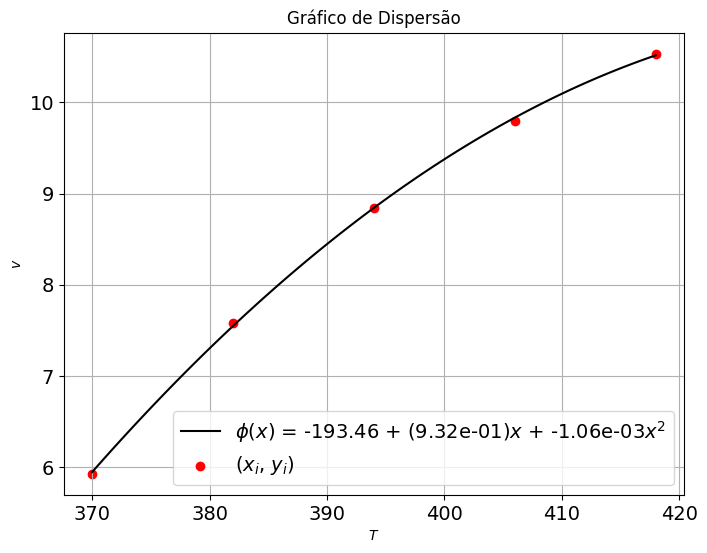

In [ ]:
# Definindo as bases
def base(x):
    return np.array([1, x, x**2])

# Encontra os coeficientes procurados
a1, a2, a3 = minquad(x, y, base, 3)

# Construindo a curva do modelo ajustado
x_vec = np.linspace(min(x), max(x), 100)
phi = a1 + a2*x_vec + a3*x_vec**2

plt.figure(figsize=(8, 6))
plt.title('Gráfico de Dispersão')
plt.grid()
plt.plot(x_vec, phi, '-', color='k', label=f'$\phi(x)$ = {a1:.2f} + ({a2:.2e})$x$ + {a3:.2e}$x^2$')
plt.scatter(x, y, color='r', label='($x_i$, $y_i$)')
plt.xlabel('$T$')
plt.ylabel('$v$')
plt.legend()
plt.show()

In [ ]:
T = 400    # Valor de interesse

# estimativa procurada
phiT = a1 + a2*T + a3*T**2


print(f'Volume específico estimado em T = {T}: {phiT:.4f}')

Volume específico estimado em T = 400: 9.3752


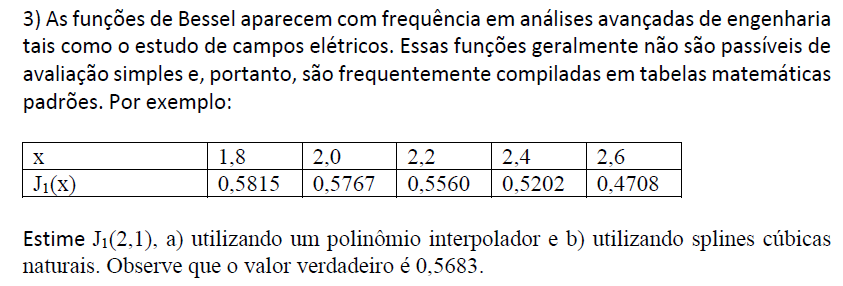

In [ ]:
import numpy as np

x, y = data3['$x$'], data3['$J_1(x)$']

# Definindo valor de interesse a ser interpolado
ponto = 2.1

# Aplicando o método de interpolação de Lagrange
J1 = lagrange(ponto, x, y)
print(f'Solução obtida através de um polinômio interpolador: J_1({ponto:.1f}) =  {J1:.4f}')

# Utilizando splines cúbicas naturais
a, b, c, d = spline_cubico(np.array(x), np.array(y))

J1_spline = a[1] + b[1]*(ponto - x[1]) + c[1]*(ponto - x[1])**2 + d[1]*(ponto - x[1])**3
print(f'Solução obtida através de splines cúbicas naturais: J_1({ponto:.1f}) =  {J1_spline:.4f}')

Solução obtida através de um polinômio interpolador: J_1(2.1) =  0.5683
Solução obtida através de splines cúbicas naturais: J_1(2.1) =  0.5685




Ao considerar 0.5683 como resultado verdadeiro, observa-se que a solução obtido por um polinômio interpolador que considera todos os cinco pontos fornecidos encontra exatamenta os mesmos quatro dígitos iniciais que os da solução de referência. A estimativa obtida através de splines cúbicos naturais, por sua vez, não é preciso até a quarta casa decimal. Esse comportamento pode ter ocorrido pelo fato de o polinômio interpolador se ajustar bem ao conjunto de pontos, sem produzir oscilações bruscas de crescimento e decrescimento entre dois pontos adjacentes.

O comportamento mencionado pode ser observado na figura a seguir, na qual percebe-se que o polinômio interpolador e os slines estão quase sobrepostos, ambos com comportamento substancialmente suave.


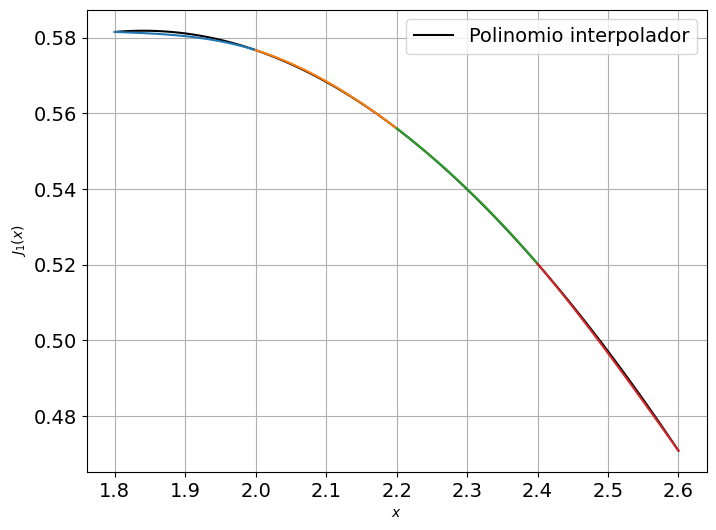

In [ ]:

pontos = np.linspace(min(x), max(x), 80)
Jpontos = lagrange(pontos, x, y)

plt.figure(figsize=(8, 6))
plt.plot(pontos, Jpontos, 'k', label = 'Polinomio interpolador')

# Cálculo das imagens geradas pelos splines cúbicos naturais
n = len(x)
for j in range (n-1):
    p = np.linspace(x[j],x[j+1],20)
    spline = a[j] + b[j]*(p - x[j]) + c[j]*(p - x[j])**2 + d[j]*(p - x[j])**3
    plt.plot(p, spline)

plt.grid()
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$J_1(x)$')
plt.show()

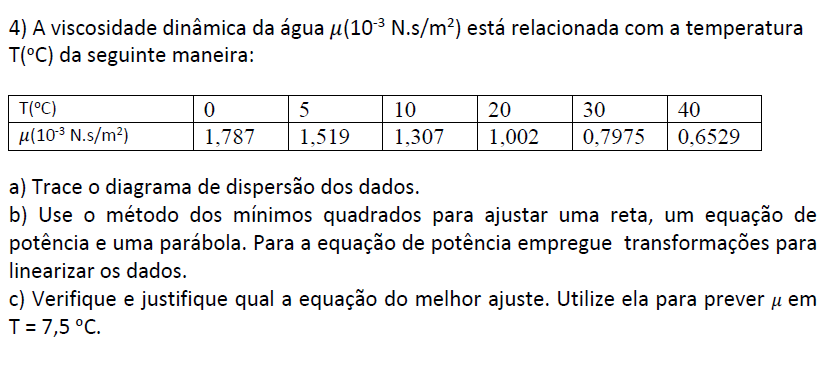

a) Trace o diagrama de dispersão dos dados.

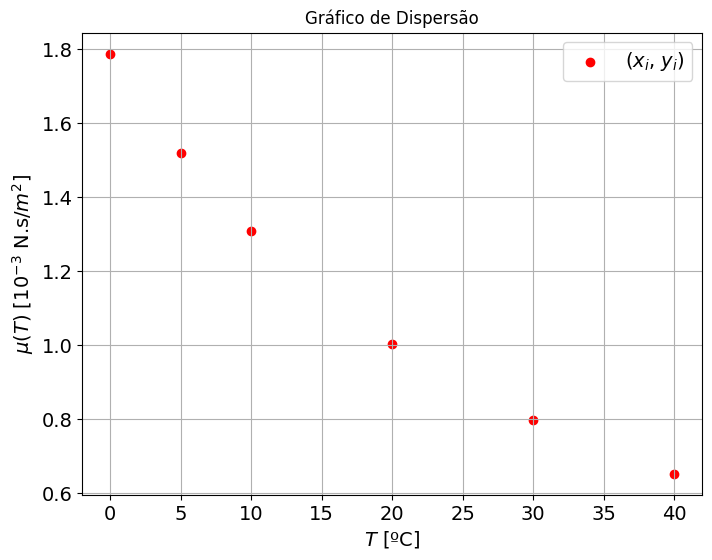

In [ ]:
x, y = data4['T [ºC]'], data4['$\mu$ [$10^{-3}$ N.s/$m^2$]']
x, y = np.array(x), np.array(y)

plt.figure(figsize=(8, 6))
plt.title('Gráfico de Dispersão')
plt.grid()
plt.scatter(x, y, color='r', label='($x_i$, $y_i$)')
plt.xlabel('$T$ [ºC]',fontsize=14)
plt.ylabel('$\mu(T)$ [$10^{-3}$ N.s/$m^2$]',fontsize=14)
plt.legend()
plt.show()

b) Use o método dos mínimos quadrados para ajustar uma reta, um equação de
potência e uma parábola. Para a equação de potência empregue transformações para
linearizar os dados.  
    Considerando a equação potência na forma:
$$y=ax^b$$

Aplicando o logaritmo natural a ambos os membros da igualdade, obtemos:
$$\ln(y)=\ln(ax^b)=\ln(a)+\ln(x^b)=\ln(a)+b\ln(x)$$

Defina $z=\ln(y)$, $w=\ln(x)$, $c_0=\ln(a)$ e c_1=b. Dessa forma, obtemos o modelo linearizado:
$$z=c_0+c_1w$$

Agora, todos os modelos são constituídos de termos lineares e podemos aplicar processos similares para gerar os coeficientes necessários.


Equação da reta:
   phi(x) = 1.66 + (-0.03)x

------------------------------------------------------------

Equação potência:
   phi(x) = 3.10x^(-4.01e-01)

------------------------------------------------------------

Equação da parábola:
   phi(x) = 1.77 + (-4.95e-02)x + (-4.95e-02)x^2

------------------------------------------------------------


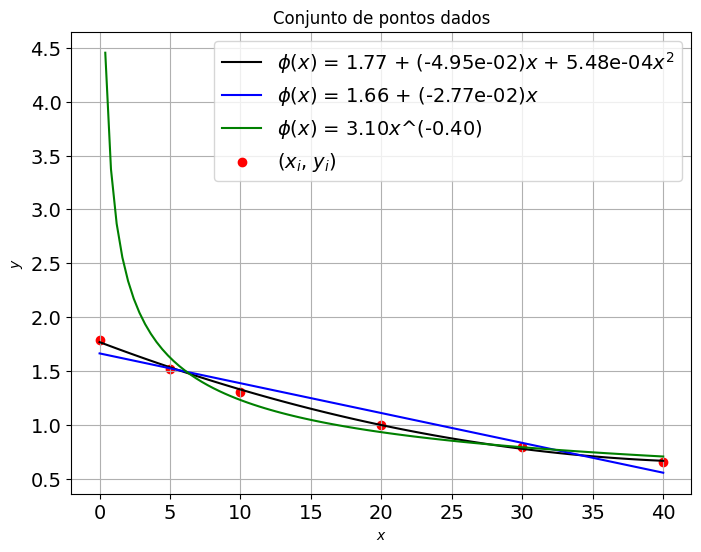

In [ ]:
# Definindo as bases
# Bases das expressoes polinomiais de primeiro grau: y = a0 + a1x
def base1(x):
    return np.array([1, x])

# Base da expressao polinomial de segundo grau: y = b0 + b1x + b2x^2
def base2(x):
    return np.array([1, x, x**2])

# Ajustando dados para gerar o modelo de uma equação potência
# Observe que como há um termo no domínio em x = 0, não podemos incluí-lo na transformação via logarítmos
z, w = np.log(y[1:]), np.log(x[1:])

# Encontra os coeficientes para ajustar os pontos:
a0, a1 = minquad(x, y, base1, 2)             # a uma reta
c0, c1 = minquad(w, z, base1, 2)             # a uma equação potência
b0, b1, b2 = minquad(x, y, base2, 3)         # a uma parábola

# Retornando ao modelo inicial da equação potência
a, b = np.exp(c0), c1

# Construindo as curvas dos modelos ajustados
x_vec = np.linspace(min(x), max(x), 100)
phi_reta = a0 + a1*x_vec
phi_potencia = a*x_vec[1:]**b
phi_parabola = b0 + b1*x_vec + b2*x_vec**2

# Modelos obtidos escritos nas variáveis originais
print('\nEquação da reta:')
print(f'   phi(x) = {a0:.2f} + ({a1:.2f})x\n')
print('-'*60)
print('\nEquação potência:')
print(f'   phi(x) = {a:.2f}x^({b:.2e})\n')
print('-'*60)
print('\nEquação da parábola:')
print(f'   phi(x) = {b0:.2f} + ({b1:.2e})x + ({b1:.2e})x^2\n')
print('-'*60)

# Geração dos gráficos
plt.figure(figsize=(8, 6))
plt.title('Conjunto de pontos dados')
plt.grid()
plt.plot(x_vec, phi_parabola, '-', color='k', label=f'$\phi(x)$ = {b0:.2f} + ({b1:.2e})$x$ + {b2:.2e}$x^2$')
plt.plot(x_vec, phi_reta, '-', color='b', label=f'$\phi(x)$ = {a0:.2f} + ({a1:.2e})$x$')
plt.plot(x_vec[1:], phi_potencia, '-', color='g', label=f'$\phi(x)$ = {a:.2f}$x$^({b:.2f})')
plt.scatter(x, y, color='r', label='($x_i$, $y_i$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

c) Verifique e justifique qual a equação do melhor ajuste. Utilize ela para prever 𝜇 em
T = 7,5 oC.

 Visualmente, a equação da parábola parece ser aquela que apresenta melhor ajuste, pois a curva passa muito próximo dos pontos impressos no gráfico anterior. Para quantificar o erro e verificar qual, de fato, é o mellhor ajuste, podemos utilizar a métrica do desvio quadrático total:
$$D = \sum_{i=0}^m\left[\phi(x_i)i - y_i\right]^2$$



In [ ]:
# Imagens estimadas
phi_reta = a0 + a1*x
phi_parabola = b0 + b1*x + b2*x**2

# Cálculo dos desvios
D_reta = np.sum( (phi_reta - y)**2 )
D_parabola = np.sum( (phi_parabola - y)**2 )

# Imprime os devios totais encontrados:
print(f'Desvio quadrático total para a reta: {D_reta:.4e}')
print(f'Desvio quadrático total para a parábola: {D_parabola:.4e}')

Desvio quadrático total para a reta: 4.3868e-02
Desvio quadrático total para a parábola: 1.6412e-03


Como o desvio quadrático total gerado pela parábola é menor, confirma que dentre os três modelos, o da parábola foi o que produziu melhor ajuste.

Então podemos usar este resultado para prever a viscosidade dinâmica quando $T=7.5^{\circ}C$:

In [ ]:
# Temperatura de interesse
T = 7.5
phiT = b0 + b1*T + b2*T**2

print(f'o valor da viscosidade dinâmica quando T = {T:.1f}ºC pode ser estimado em: {phiT:.4f}')


o valor da viscosidade dinâmica quando T = 7.5ºC pode ser estimado em: 1.4269
